In [3]:
import pandas as pd 
import numpy as np 

In [4]:
df = pd.read_csv('data/addresses_and_tweets.csv')

# Load data and drop duplicates

In [5]:
df = df.drop_duplicates(subset='text').reset_index(drop=True)

# Balance

In [6]:
def balance_classes(df, column_name):
    """Balance the classes of a binary column in a dataframe."""
    counts = df[column_name].value_counts()
    # Check if classes are already balanced
    if counts.min() == counts.max():
        return df
    # Identify majority and minority classes
    majority_class = counts.idxmax()
    minority_class = counts.idxmin()
    # Randomly select instances from majority class to remove
    majority_indices = df[df[column_name] == majority_class].index
    num_instances_to_remove = len(majority_indices) - counts[minority_class]
    indices_to_remove = np.random.choice(majority_indices, size=num_instances_to_remove, replace=False)
    # Remove instances from majority class
    df = df.drop(indices_to_remove)
    return df.reset_index(drop=True)

df = balance_classes(df, 'is_address')

In [7]:
df.is_address.value_counts()

is_address
0    761548
1    761548
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split
# Split the dataset into a training set and a testing set
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['is_address'], test_size=0.4, random_state=42)


# Logistic Regression

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression #, SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(x_train)

# transform the documents in the training data to a document-term matrix
x_train_vectorized = vect.transform(x_train)

model = LogisticRegression(max_iter=1000)
model.fit(x_train_vectorized, y_train)
predictions = model.predict(vect.transform(x_test))

print('AUC: ', roc_auc_score(y_test, predictions))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

AUC:  0.9998801797200192


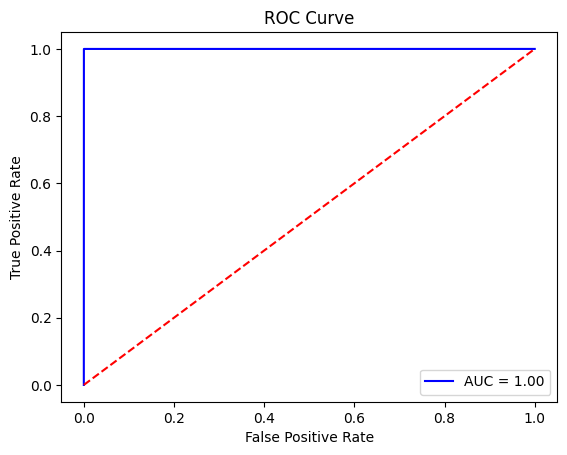

In [12]:
import matplotlib.pyplot as plt
# Plot ROC curve
plt.plot(false_positive_rate, true_positive_rate, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [14]:
for text in df['text'].sample(n=20, random_state=42):
    is_address = '1 - address    ' if model.predict(vect.transform([text]))[0] else '0 - not_address'
    print(f'{is_address} : {text}')

0 - not_address : i want to feel well again. it's not fair  i'm sick of feeling sick.
1 - address     : 425 creek rd  wallingford rutland vt 05773 
1 - address     : 20 vine street     02129 
0 - not_address : is revising for her french gcse this afternoon  x
0 - not_address : i can cry all i want, and i can wish for things to be different. but that won't change reality 
1 - address     : 474 tremont street apt 38    02118 
0 - not_address : http://tinyurl.com/ry9wap hi there! how are you? nice pics  ;) let`s be friends! i can email you some my pictures. please give me your ...
1 - address     : 50 point of tongue  alburgh grand isle vt 05440 
1 - address     : 78 railroad st  johnson lamoille vt 05656 
0 - not_address : @nikki_lopez nobody went out...so i didn't do anything 
1 - address     : 96 eves dr  londonderry windham vt 05155 
1 - address     : 12 horace street     02128 
0 - not_address : @wolwol hello wol! thanks for your enthusiastic hello!!!!! 
1 - address     : 107 homeste

In [16]:
import joblib

# Save the trained model
joblib.dump(model, f'output/lr_model.pkl')
joblib.dump(vect,  f'output/lr_cvectorizer.joblib')

['output/lr_cvectorizer.joblib']

In [2]:
import joblib
model = joblib.load(f'output/lr_model.pkl')
vect  = joblib.load(f'output/lr_cvectorizer.joblib')

In [5]:
%%timeit
predictions = model.predict(vect.transform(['hahah test 123']))

72.5 µs ± 132 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
